<a href="https://colab.research.google.com/github/SLVmain/Deep_Learning/blob/main/HW_13_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание

Создайте автокодировщик, удаляющий черные квадраты в лучшайных областях изображений.

Алгоритм действий:
1. Возьмите базу картинок Mnist.
2. На картинках в случайных местах сделайте чёрные квадраты размера 8 на 8.
3. Создайте и обучите автокодировщик восстанавливать оригинальные изображения из "зашумленных" квадратом изображений.
4. Добейтесь MSE < 0.0070 на тестовой выборке

## Импорт библиотек

In [ ]:
# Отображение
import matplotlib.pyplot as plt

# Для работы с тензорами
import numpy as np 

# Класс создания модели
from tensorflow.keras.models import Model

# Для загрузки данных
from tensorflow.keras.datasets import mnist

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Функции-утилиты
from tensorflow.keras import utils
import os

from tensorflow.keras.models import load_model

%matplotlib inline

## Данные

In [ ]:
# Загрузка данных
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
X_train[2,:,:].shape

(28, 28)

In [ ]:
X_train[2].shape

(28, 28)

In [ ]:
def add_black_sq(data, size=8):
    a = np.random.randint(0, 21)
    b = np.random.randint(0, 21)

    for i in range(size):
      for j in range(size):
        data[a+j][b+i] = 255

    return data

In [ ]:
X_train_ = np.copy(X_train)
X_test_ = np.copy(X_test)

In [ ]:
X_train_sq = []
for i in range(len(X_train)):
  
  X_train_sq.append(add_black_sq(X_train_[i]))

In [ ]:
X_test_sq = []
for i in range(len(X_test)):
  
  X_test_sq.append(add_black_sq(X_test_[i]))

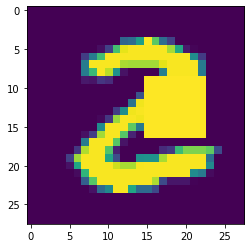

In [ ]:
plt.imshow(X_train_sq[25])
plt.show()

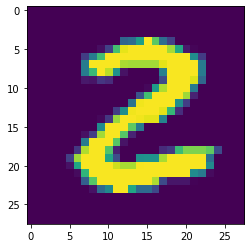

In [ ]:
plt.imshow(X_train[25])
plt.show()

In [ ]:
X_train_sq = np.array(X_train_sq)
X_test_sq = np.array(X_test_sq)

In [ ]:
# Нормировка данных
X_train = X_train.astype('float32')/255.
X_train_sq = X_train_sq.astype('float32')/255.
X_test = X_test.astype('float32')/255.
X_test_sq = X_test_sq.astype('float32')/255.

In [ ]:
# Изменение формы под удобную для Keras
X_train = X_train.reshape((-1, 28, 28, 1))      # это будет целевая картинка - y
X_train_sq = X_train_sq.reshape((-1, 28, 28, 1)) # это будет исходник
X_test = X_test.reshape((-1, 28, 28, 1))
X_test_sq = X_test_sq.reshape((-1, 28, 28, 1))

## Автокодировщик

In [ ]:
# Функция сборки свёрточного автокодировщика
def create_base_ae(in_shape):

  # Входной слой 
  inputs = Input(in_shape)

  # Энкодер
  # ---------------------------------------------------------------

  # 3 блока свертки перед сжатием 
  x = Conv2D(12, 3, padding='same', activation='relu')(inputs)
  x = BatchNormalization()(x)

  # используем разрежение (dilation_rate) для выявления мелких деталей изображения
  x = Conv2D(24, 3, dilation_rate=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 1
  x = Conv2D(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(96, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 2
  x = Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(256, 3, padding='same', activation='relu')(x)

  # Скрытое пространство
  z = BatchNormalization()(x)

  # Декодер
  # ---------------------------------------------------------------
  # Расширение 2
  x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(z)
  x = BatchNormalization()(x)

  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Расширение 1
  x = Conv2DTranspose(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(24, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(8, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # финальный слой свертки, выход модели
  outputs = Conv2D(1, 2, dilation_rate=2, padding='same', activation='sigmoid')(x)

  # Сборка модели. На входе оригинальное изображение, на выходе - сжатое-восстановленное
  model = Model(inputs, outputs)

  # компиляция модели
  model.compile(optimizer=Adam(1e-4),
                loss='mse')

  return model

###Сервисные функции

In [ ]:
# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(target_images, noised_images, pred, shape=None, n=4): 
    if shape is None:                               # Автоопределение формы данных
        shape = target_images.shape[1:3]                   # форма изображения 

    plt.figure(figsize=(n*4, n*4), dpi=100)                     # Размер полотна
    plt.subplots_adjust(hspace=0.2, wspace=0.001)

    for i in range(0, n):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса 

        # Показ картинки с индексом index из оригинального набора
        ax = plt.subplot(n, 4, 4*i + 1)               # Картинка располагается в верхнем ряду
        plt.imshow(target_images[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False)
        ax.set_title('Оригинал')

        # Показ шумовой картинки с тем же индексом
        ax = plt.subplot(n, 4, 4*i + 2)           # Картинка располагается в среднем ряду
        plt.imshow(noised_images[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Зашумлённое изображение')

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(n, 4, 4*i + 3)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Предсказание')

        # Показ разницы предсказания и зашумленной картинки
        ax = plt.subplot(n, 4, 4*i + 4)           # Картинка располагается в нижнем ряду
        plt.imshow(noised_images[index].reshape(shape) - pred[index].reshape(shape),
                   cmap='gray', vmin=0, vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Извлечённый шум')
    
    plt.show()

Рассмотрите константы, которые в дальнейшем вам потребуются.

In [ ]:
# Настройка констант

IMG_HEIGHT = 28                          # Высота изображений
IMG_WIDTH = 28                            # Ширина избражений
VAL_SPLIT = 0.05                          # Доля проверочной выборки от основного набора

In [ ]:
# Выбор индекса случайного изображения из тренировочных
random_index = np.random.randint(0, X_train.shape[0])

Для визуализации можно использовать `plt`. <br>
При одноканальных изображениях этот фреймворк требует убирать уже лишнюю ось каналов, так как она всего одна, поэтому избыточна. Это можно сделать функцией `.squeeze()`.

In [ ]:
# Удаление последней оси для корректной работы plt
random_img = X_train[random_index].squeeze(axis=-1)

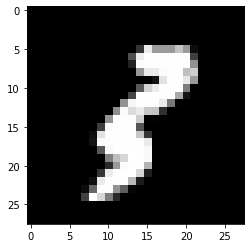

In [ ]:
# Вывод примера в черно-белом формате
plt.imshow(random_img, cmap='gray')
plt.show()

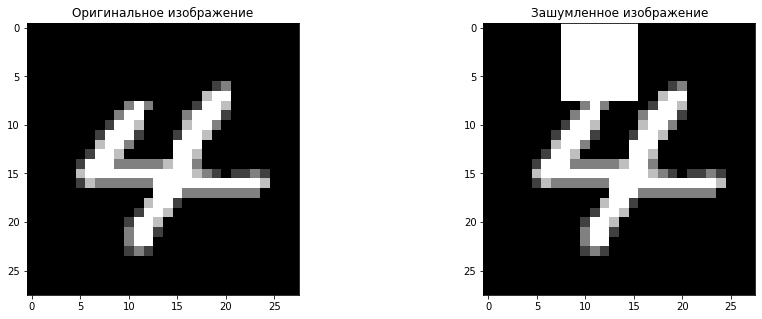

In [ ]:
# Создаем полотно
fig = plt.figure(figsize=(15, 5))

# Выбираем индекс изображения случайно
choice = np.random.randint(0, X_train.shape[0])

# Создаем области ax для отрисовки изображений
ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)

# Отрисовываем изображения
ax_1.imshow(X_train[choice].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
ax_2.imshow(X_train_sq[choice].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')

# Подписываем
ax_1.set_title('Оригинальное изображение')
ax_2.set_title('Зашумленное изображение')

# прописываем пустую инструкцию, иначе выведется значение, возвращенное ax_2 (которое нам не нужно)
pass

###Создание и обучение автокодировщика

In [ ]:
# Создание автокодировщика
ae_faces = create_base_ae(X_train.shape[1:])

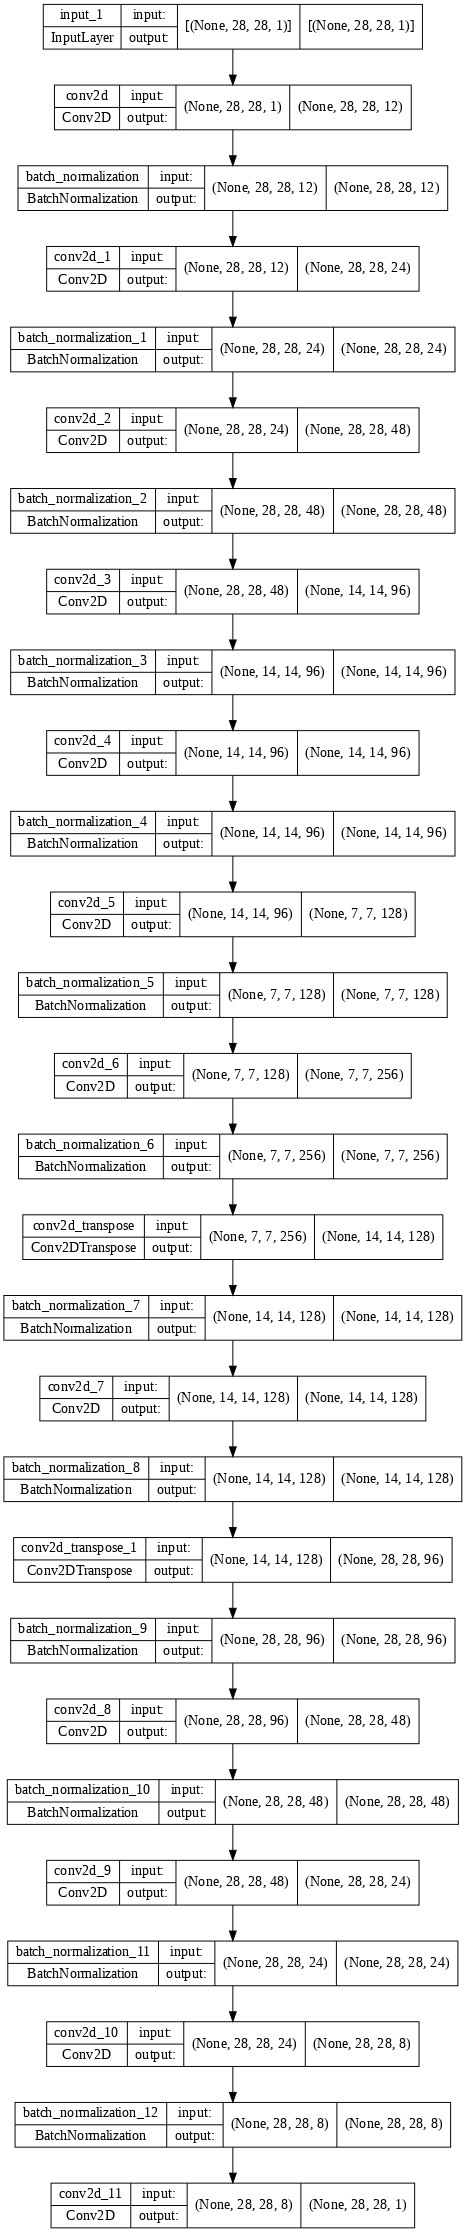

In [ ]:
# Отображение модели
utils.plot_model(ae_faces, show_shapes=True, dpi=70)

In [ ]:
# Обучение модели на датасете лиц
ae_faces.fit(X_train_sq, X_train,
             epochs=50, 
             batch_size=8,
             validation_data=(X_test_sq, X_test))

Epoch 1/50
7500/7500 [==============================] - 75s 9ms/step - loss: 0.0157 - val_loss: 0.0054
Epoch 2/50
7500/7500 [==============================] - 64s 9ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 3/50
7500/7500 [==============================] - 60s 8ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 4/50
7500/7500 [==============================] - 63s 8ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/50
7500/7500 [==============================] - 64s 9ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 6/50
7500/7500 [==============================] - 63s 8ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 7/50
7500/7500 [==============================] - 63s 8ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 8/50
7500/7500 [==============================] - 63s 8ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 9/50
7500/7500 [==============================] - 61s 8ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 10/50
7500/7500 [==============================] - 62s 8ms/step - l

In [ ]:
pred_train = ae_faces.predict(X_train_sq)
pred_test = ae_faces.predict(X_test_sq)

In [ ]:
# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Расчет количества пикселей изображения
image_size = X_train.shape[1] * X_train.shape[2]

# Расчет массивов среднеквадратических ошибок по всем картинкам тренировочной и тестовой выборок.
# mean_squared_error() ожидает двумерный вектор, для чего каждую картинку придется
# "сплющить" до одномерного вектора размера image_size
err_train = mean_squared_error(X_train.reshape(-1, image_size).T, 
                                     pred_train.reshape(-1, image_size).T,
                                     multioutput='raw_values')
err_test = mean_squared_error(X_test.reshape(-1, image_size).T,
                                    pred_test.reshape(-1, image_size).T,
                                    multioutput='raw_values')

# Вывод средних ошибок
print(f'Средняя ошибка на обучающем наборе MNIST: {err_train.mean()}')
print(f'Средняя ошибка на  тестовом наборе MNIST: {err_test.mean()}')

Средняя ошибка на обучающем наборе MNIST: 0.0006123779457993805
Средняя ошибка на  тестовом наборе MNIST: 0.002711695618927479


### Сохранение

Создадите папку для модели.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Путь к папке для хранения моделей
PATH = '/content/drive/MyDrive/Colab Notebooks/data/my_ae_models'

# Создадим папку для моделей, если её еще нет
if not os.path.isdir(PATH):
  os.mkdir(PATH)

На первой практике вы сохранили веса модели. Это был первый способ сохранения результата. Второй способ – сохранить саму модель. Делается это через метод `ae_faces.save`. Загрузка через `tf.keras.models.load_model`

In [ ]:
# Сохранение/восстановление всей модели
ae_faces.save(PATH + '/ae_faces') # Сохраняем модель
ae_faces = load_model(PATH + '/ae_faces') # Загружаем модель

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/data/my_ae_models/ae_faces/assets


###Проверка результатов

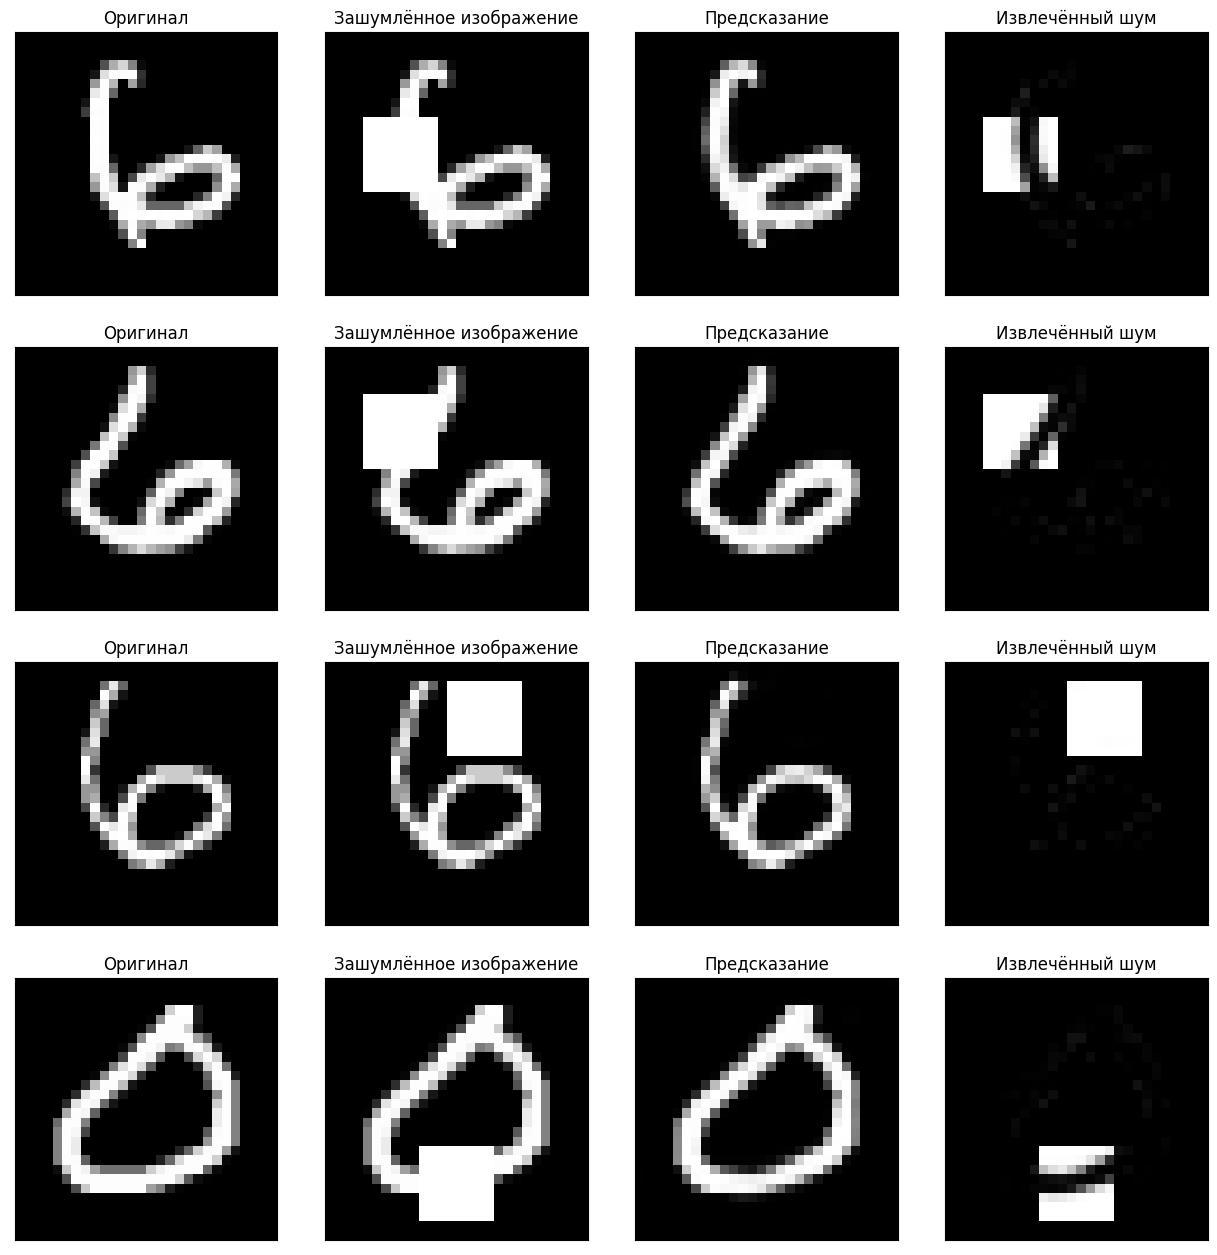

In [ ]:
# Сравнение исходных и восстановленных картинок из обучающей выборки
plot_images(X_test, X_test_sq, pred_test)

# еще архитектура

In [ ]:
def create_ae(in_shape):

  # Входной слой 
  inputs = Input(in_shape)

  # Энкодер
  # ---------------------------------------------------------------

  # 3 блока свертки перед сжатием 
  x = Conv2D(48, 3, padding='same', activation='relu')(inputs)
  x = BatchNormalization()(x)

  # используем разрежение (dilation_rate) для выявления мелких деталей изображения
  x = Conv2D(48, 3, dilation_rate=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 1
  x = Conv2D(96, 3, dilation_rate=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(96, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 2
  x = Conv2D(256, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(256, 3, padding='same', activation='relu')(x)

  # Скрытое пространство
  z = BatchNormalization()(x)

  # Декодер
  # ---------------------------------------------------------------
  # Расширение 2
  x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(z)
  x = BatchNormalization()(x)

  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Расширение 1
  x = Conv2DTranspose(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(24, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(8, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # финальный слой свертки, выход модели
  outputs = Conv2D(1, 2, padding='same', activation='sigmoid')(x)

  # Сборка модели. На входе оригинальное изображение, на выходе - сжатое-восстановленное
  model = Model(inputs, outputs)

  # компиляция модели
  model.compile(optimizer=Adam(1e-4),
                loss='mse')

  return model

In [ ]:
# Создание автокодировщика
ae_1 = create_ae(X_train.shape[1:])

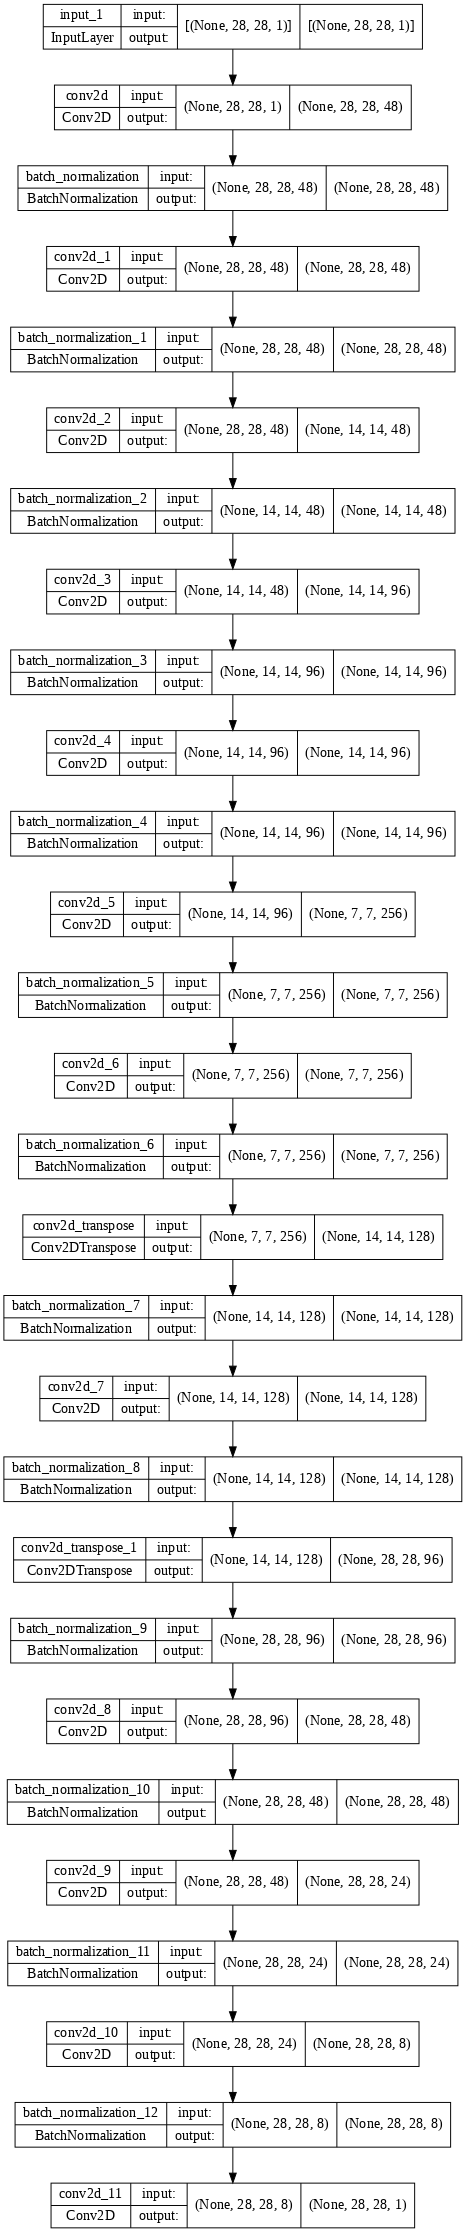

In [ ]:
# Отображение модели
utils.plot_model(ae_1, show_shapes=True, dpi=70)

In [ ]:
# Обучение модели на датасете лиц
ae_1.fit(X_train_sq, X_train,
             epochs=50, 
             batch_size=8,
             validation_data=(X_test_sq, X_test))

Epoch 1/50
7500/7500 [==============================] - 66s 7ms/step - loss: 0.0166 - val_loss: 0.0052
Epoch 2/50
7500/7500 [==============================] - 54s 7ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 3/50
7500/7500 [==============================] - 54s 7ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 4/50
7500/7500 [==============================] - 54s 7ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 5/50
7500/7500 [==============================] - 54s 7ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 6/50
7500/7500 [==============================] - 54s 7ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 7/50
7500/7500 [==============================] - 53s 7ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 8/50
7500/7500 [==============================] - 54s 7ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 9/50
7500/7500 [==============================] - 54s 7ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 10/50
7500/7500 [==============================] - 53s 7ms/step - l

In [ ]:
pred_train = ae_1.predict(X_train_sq)
pred_test = ae_1.predict(X_test_sq)

In [ ]:
# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Расчет количества пикселей изображения
image_size = X_train.shape[1] * X_train.shape[2]

# Расчет массивов среднеквадратических ошибок по всем картинкам тренировочной и тестовой выборок.
# mean_squared_error() ожидает двумерный вектор, для чего каждую картинку придется
# "сплющить" до одномерного вектора размера image_size
err_train = mean_squared_error(X_train.reshape(-1, image_size).T, 
                                     pred_train.reshape(-1, image_size).T,
                                     multioutput='raw_values')
err_test = mean_squared_error(X_test.reshape(-1, image_size).T,
                                    pred_test.reshape(-1, image_size).T,
                                    multioutput='raw_values')

# Вывод средних ошибок
print(f'Средняя ошибка на обучающем наборе MNIST: {err_train.mean()}')
print(f'Средняя ошибка на  тестовом наборе MNIST: {err_test.mean()}')

Средняя ошибка на обучающем наборе MNIST: 0.000551462231669575
Средняя ошибка на  тестовом наборе MNIST: 0.0026801181957125664


#MSE немного улучшилась